# Install Required Libraries

In [1]:
import math
!pip install ucimlrepo
!pip install scikit-learn

# Download Miles Per Gallon Dataset

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# Combine features and target into one DataFrame for easy filtering
data = pd.concat([X, y], axis=1)

# Drop rows where the target variable is NaN
cleaned_data = data.dropna()

# Split the data back into features (X) and target (y)
X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

# Display the number of rows removed
rows_removed = len(data) - len(cleaned_data)
print(f"Rows removed: {rows_removed}")

Rows removed: 6


# Training, Validation, Testing Split and Data Standardization

In [3]:
from sklearn.model_selection import train_test_split

# Do a 70/30 split (e.g., 70% train, 30% other)
X_train, X_leftover, y_train, y_leftover = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,    # for reproducibility
    shuffle=True,       # whether to shuffle the data before splitting
)

# Split the remaining 30% into validation/testing (15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_leftover, y_leftover,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)

# Compute statistics for X (features)
X_mean = X_train.mean(axis=0)  # Mean of each feature
X_std = X_train.std(axis=0)    # Standard deviation of each feature

# Standardize X
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Compute statistics for y (targets)
y_mean = y_train.mean()  # Mean of target
y_std = y_train.std()    # Standard deviation of target

# Standardize y
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [10]:
X_train.shape

(274, 7)

In [4]:
print(f"Samples in Training:   {len(X_train)}")
print(f"Samples in Validation: {len(X_val)}")
print(f"Samples in Testing:    {len(X_test)}")

Samples in Training:   274
Samples in Validation: 59
Samples in Testing:    59


# Define our Linear Regression Model

In [5]:
import numpy as np
import math

def mse_loss(y_pred: np.ndarray, y_actual: np.ndarray):
    """
    Calculate the Mean Squared Error loss
    :param y_pred: predicted y values
    :param y_actual: actual y values
    :return: mean squared error
    """
    return 1 / 2 * np.mean(np.square(y_pred - y_actual.flatten()))


def mse_loss_gradient(x: np.ndarray, y_pred: np.ndarray, y_actual: np.ndarray):
    """
    Calculate the partial derivative of the MSE loss function wrt weights and bias
    :param x: x data
    :param y_pred: predicted y data
    :param y_actual: actual y data
    :return: derivative of loss wrt (weight, bias)
    """
    error = y_pred - y_actual.flatten()

    dL_dw = x.T @ error
    dL_db = np.sum(error)

    return dL_dw / len(x), dL_db / len(x)


class LinearRegression:
    def __init__(self, num_features: int, y_mean: float, y_std: float):
        """
        Linear Regression, training and prediction
        :param num_features: (int) number of input features
        :param y_mean: mean of y training dist
        :param y_std: standard deviation of y training dist
        """
        self.num_features = num_features
        self.y_mean = y_mean
        self.y_std = y_std

        # Randomly sample weights and biases from Normal distribution
        self.w = np.random.normal(size=num_features) * 0.01
        self.b = 0.0

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Perform prediction/inference
        :param x: input data
        :return: standardized results
        """
        assert x.shape[1] == self.num_features, "Input features do not match initialized weights."

        return self.w @ x.T + self.b

    def predict_mpg(self, x: np.ndarray) -> np.ndarray:
        """
        Perform prediction/inference
        :param x: input data
        :return: results
        """
        return self.predict(x) * self.y_std + self.y_mean

    def train(self,
              X: np.ndarray, y: np.ndarray,
              X_val: np.ndarray, y_val: np.ndarray,
              learning_rate: float=1E-3, batch_size: int=8, epochs=30):
        """
        Train the linear regression model

        :param X: Training data, 2D numpy array, rows are samples and columns are features
        :param y: Training targets, numpy array of target values
        :param X_val: Validation data, same format as X
        :param y_val: Validation targets, same format as y
        :param learning_rate: training learning rate
        :param batch_size: size of each batch
        :param epochs: number of epochs to train for
        :return: training loss, validation loss (np.ndarray, np.ndarray)
        """
        assert len(X) == len(y), "Number of samples in X and y do not match."

        x_batches = np.array_split(X, math.ceil(len(X) / batch_size), axis=0)
        y_batches = np.array_split(y, math.ceil(len(y) / batch_size), axis=0)

        train_losses = []
        val_losses = []

        for i in range(epochs):
            total_loss = 0
            bi = 0
            for bx, by in zip(x_batches, y_batches):
                y_pred = self.predict(bx)

                loss = mse_loss(y_pred, by)
                wgrad, bgrad = mse_loss_gradient(bx, y_pred, by)

                self.w -= learning_rate * wgrad
                self.b -= learning_rate * bgrad

                total_loss += loss
                bi += 1

            val_loss = mse_loss(self.predict(X_val), y_val)
            train_loss = total_loss / len(x_batches)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {i}  :::  Train Loss={train_loss}  :::  Val Loss={val_loss}")

        return np.array(train_losses), np.array(val_losses)

# Initialize Model and Train it

In [6]:
linreg = LinearRegression(7, y_mean, y_std)
training_loss, validation_loss = linreg.train(X_train.to_numpy(),
                                              y_train.to_numpy(),
                                              X_val.to_numpy(),
                                              y_val.to_numpy(),
                                              epochs=100)

Epoch 0  :::  Train Loss=0.46914017745869663  :::  Val Loss=0.3630950465002619
Epoch 1  :::  Train Loss=0.37422411069090966  :::  Val Loss=0.2925761719856473
Epoch 2  :::  Train Loss=0.305127916305932  :::  Val Loss=0.24163337495085005
Epoch 3  :::  Train Loss=0.2547493875929099  :::  Val Loss=0.2048129794922955
Epoch 4  :::  Train Loss=0.2179432069049859  :::  Val Loss=0.17817438810288366
Epoch 5  :::  Train Loss=0.19098165400686049  :::  Val Loss=0.15887161519570128
Epoch 6  :::  Train Loss=0.1711639321097217  :::  Val Loss=0.14485034606992345
Epoch 7  :::  Train Loss=0.15653315719442465  :::  Val Loss=0.13462865856061934
Epoch 8  :::  Train Loss=0.14567134167881368  :::  Val Loss=0.12713832836580685
Epoch 9  :::  Train Loss=0.13755087915350023  :::  Val Loss=0.12161000191845807
Epoch 10  :::  Train Loss=0.13142695970770968  :::  Val Loss=0.11749012980512129
Epoch 11  :::  Train Loss=0.12675963608292348  :::  Val Loss=0.11438089242612894
Epoch 12  :::  Train Loss=0.12315736925621967 

# Plot the Loss Curve

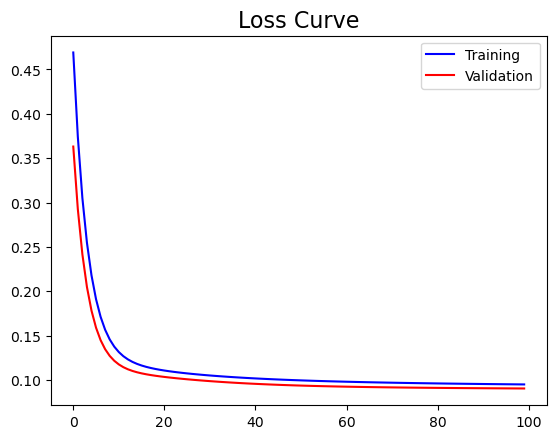

In [7]:
import matplotlib.pyplot as plt

plt.plot(training_loss, color='b', label='Training')
plt.plot(validation_loss, color='r', label="Validation")
plt.title("Loss Curve", size=16)
plt.legend()

# Evaluate on Testing Dataset

In [8]:
testing_predictions = linreg.predict(X_test.to_numpy())
testing_loss = mse_loss(testing_predictions, y_test.to_numpy())
print(f'Testing Loss: {testing_loss}')

Testing Loss: 0.0896793189786334


## Predict MPG for Test Set

In [9]:
linreg.predict_mpg(X_test.to_numpy())

array([19.55004481, 18.44181701, 29.1632812 ,  8.95297252, 23.30714932,
       18.55267431,  8.8600375 , 11.03275429, 26.67486159, 29.30569638,
       27.9749313 , 32.2405207 , 25.87755428, 23.07658873, 33.67136202,
       23.15874173, 18.00322197, 26.50187346, 11.29487713, 18.91628273,
       30.07444704, 13.963758  , 21.28508187, 34.09885573, 13.38608586,
       16.47729645, 29.4897148 , 23.12657453, 25.54103966, 28.93115916,
       26.67926117, 34.74303207, 13.28852899, 18.33924893, 22.4502953 ,
       14.05167215, 25.40180581, 27.42622374, 28.86074738, 32.21496608,
       31.6458738 , 20.94337295, 28.29482837, 31.64825781, 13.84795692,
       30.64498723, 14.05064086, 29.60004103,  7.80746748, 30.2378969 ,
       35.38690697, 21.06542439, 28.55182755, 12.20392983, 33.29618501,
       30.81751278, 27.54222066, 24.24398954, 26.51705388])